In [36]:
import requests
from bs4 import BeautifulSoup
import time

In [2]:
def fetch(query = None, auto_make_model = None, min_auto_year = None, max_auto_year = None, s=0):
    search_params = {key: val for key, val in locals().items() if val is not None}
    if not search_params: 
        raise ValueError("No valid keywords")
        
    base = "http://boston.craigslist.org/search/cto"
    resp = requests.get(base, params=search_params, timeout=3)
    resp.raise_for_status()
    return resp.content, resp.encoding

In [3]:
def parse(html, encoding='utf-8'):
    parsed = BeautifulSoup(html, 'lxml', from_encoding=encoding)
    return parsed

In [4]:
def extract_listings(parsed):
    listings = parsed.find_all('p', class_='result-info')
    extracted = []
    for listing in listings:
        title = listing.find('a', class_='result-title hdrlnk')
        price = listing.find('span', class_='result-price')
        try:
            price_string = price.string.strip()
        except AttributeError:
            price_string = ''
        location = listing.find('span', class_='result-hood')
        try:
            loc_string = location.string.strip()[1:-1].split()[0]
        except AttributeError:
            loc_string = ''
        this_listing = {
            'link': title.attrs['href'],
            'description': title.string.strip(),
            'price': price_string,
            'location': loc_string
        }
        extracted.append(this_listing)
    return extracted

In [5]:
import pandas as pd
import numpy as np

In [6]:
import re

def get_mileage(description):
    description = description.lower().split('k miles')
    if len(description) == 1:
        description = description[0].split('000 miles')
        if len(description) == 1:
            try:
                description = re.search('(\d{1,3})k', description[0]).groups()
            except:
                return np.nan
    mileage = re.sub('[^0-9]', '', description[0].split()[-1])
    try:
        mileage = int(mileage) * 1000
        return mileage
    except:
        return np.nan

In [16]:
def get_year(description):
    description = re.split('(20[0-9][0-9])', description)
    if len(description) == 1:
        description = re.split('(19[0-9][0-9])', description[0])
    if len(description) == 1:
        description = re.split('([0-1][0-9])', description[0])
    if len(description) == 1:
        return np.nan
    if len(description[1]) == 4: 
        year = description[1]
    elif int(description[1]) > 17: 
        year = '19' + description[1]
    else: 
        year = '20' + description[1]
    try:
        return int(year) if int(year) <= 2017 else np.nan
    except:
        return np.nan

In [24]:
def get_standard_location(location):
    """
    Use first 5 characters of location in order to group. Gets rid of much of the weird stuff
    """
    if len(location) < 5:
        return re.sub('[^a-z]', '', location.lower())
    else:
        return re.sub('[^a-z]', '', location[:5].lower())

In [9]:
def get_price(price):
    try:
        return int(price[1:]) if int(price[1:]) > 100 else np.nan
    except:
        return np.nan

In [111]:
def scrape_all(search_params={}):
    listings = []
    base = "http://boston.craigslist.org/search/cto"
    for i in range(0, 1000, 100):
        search_params['s'] = i
        resp = requests.get(base, params=search_params, timeout=3)
        resp.raise_for_status()
        with open('sizing.txt', 'a+') as f:
            f.write(resp.content)
        f.close()
        car_results = resp.content, resp.encoding
        doc = parse(car_results[0])
        listings.extend(extract_listings(doc))
        time.sleep(2)
    
    df = pd.DataFrame(data=listings)
    
    df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
    df['price'] = df.apply(lambda row: get_price(row['price']), axis=1)
    df['region'] = df['link'].str[1:5]
    df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
    df['std_location'] = df.apply(lambda row: get_standard_location(row['location']), axis=1)
    df = df.drop_duplicates()
    
    return df

In [108]:
all_car_info = scrape_all()
print len(all_car_info)
all_car_info = all_car_info.append(scrape_all(search_params={'searchNearby': 1}))
print len(all_car_info)
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

2407
4907
2545


In [109]:
all_car_info = all_car_info.append(scrape_all(search_params={'sort': 'pricedsc'}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

4718


In [110]:
all_car_info = all_car_info.append(scrape_all(search_params={'sort': 'priceasc'}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

6923


In [112]:
all_car_info = all_car_info.append(scrape_all(search_params={'auto_transmission': 1}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

7418


In [113]:
all_car_info['std_location'] = all_car_info.apply(lambda row: re.sub('[^a-z]', '', row['std_location']), axis=1)
all_car_info.head()

,description,link,location,price,mileage,region,year,std_location
0,1996 jeep cherokee xj trade for truck,/nwb/cto/5987182859.html,Lowell,2500.0,NaN,nwb/,1996.0,lowel
1,07 volvo s40 T5 AWD,/sob/cto/6007357742.html,Taunton,7500.0,NaN,sob/,2007.0,taunt
2,2010 Subaru Forester 2.5X,/nos/cto/5988195757.html,Revere,8750.0,NaN,nos/,2010.0,rever
3,00 FORD 150 4\4 LOW MILES PLOW SET UP..,/nos/cto/5995359138.html,seabrook,1800.0,NaN,nos/,2000.0,seabr
4,2007 Chevy Cobalt,/nwb/cto/6007355695.html,Haverhill,1800.0,NaN,nwb/,2007.0,haver


In [245]:
all_car_info.set_index('link', inplace=True)
all_car_info.head()

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/nwb/cto/5987182859.html,1996 jeep cherokee xj trade for truck,Lowell,2500.0,NaN,nwb/,1996.0,lowel
/sob/cto/6007357742.html,07 volvo s40 T5 AWD,Taunton,7500.0,NaN,sob/,2007.0,taunt
/nos/cto/5988195757.html,2010 Subaru Forester 2.5X,Revere,8750.0,NaN,nos/,2010.0,rever
/nos/cto/5995359138.html,00 FORD 150 4\4 LOW MILES PLOW SET UP..,seabrook,1800.0,NaN,nos/,2000.0,seabr
/nwb/cto/6007355695.html,2007 Chevy Cobalt,Haverhill,1800.0,NaN,nwb/,2007.0,haver


In [246]:
import pandas_profiling
pandas_profiling.ProfileReport(all_car_info)

Number of variables,8
Number of observations,7417
Total Missing (%),13.9%
Total size in memory,463.6 KiB
Average record size in memory,64.0 B
Numeric,3
Categorical,5
Date,0
Text (Unique),0
Rejected,0
Distinct count,6691


In [248]:
all_car_info.to_csv("all_car_info.csv", encoding='utf-8')

Methods of getting more (older) results:

-include nearby areas (searchNearby=1)

-sort by price (sort=pricedsc or sort=priceasc)

-manual transmission (auto_transmission=1)

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("ticks")

(1950, 2020.0073466988508)

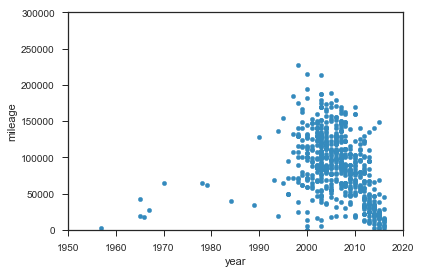

In [250]:
all_car_info.plot.scatter('year', 'mileage')
plt.ylim(0,3E5)
plt.xlim(1950,)

(0, 200000.0)

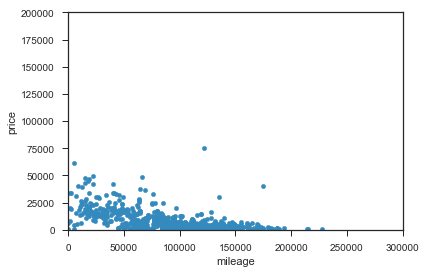

In [251]:
all_car_info.plot.scatter('mileage', 'price')
plt.xlim(0,3E5)
plt.ylim(0,2E5)

(1950, 2020)

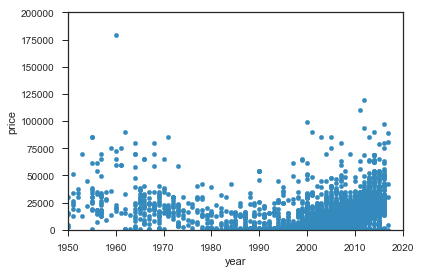

In [252]:
all_car_info.plot.scatter('year', 'price')
plt.ylim(0,2E5)
plt.xlim(1950,2020)

In [147]:
print all_car_info[all_car_info['price'] >= 150000]

                                       description                      link  \
854                     2015 mercedes sprinter van  /bmw/cto/6006712769.html   
0    99 Audi A4 2.8 and 02 Audi A4 1.8t for Parts!  /sob/cto/5965640273.html   
1                                           nissan  /gbs/cto/5973931006.html   
2                       Wanted International Scout  /gbs/cto/5940852470.html   
3         1936 Mercedes-Benz 540K Special Roadster  /gbs/cto/5973881754.html   
4                               Peterbilt 389 v100  /gbs/cto/5967894374.html   
6            2013 Toyota Tacoma Trd sport crew cab  /gbs/cto/5974877040.html   
7                         1960 Mercedes Benz 190SL  /gbs/cto/5964635170.html   

      location       price   mileage region    year std_location  
854    Norfolk    320000.0       NaN   bmw/  2015.0        norfo  
0       Quincy  20002500.0       NaN   sob/  2002.0        quinc  
1                3434535.0       NaN   gbs/     NaN               
2     Anywh

In [ ]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Year')
ax1.set_ylabel('Price($)')
ax1.set_title('Price vs Mileage and Year for Used Honda Civics, 2000-2016', y= 1.2)
plt.plot(df['year'], df['price'], '.', ms=10, label='year')
ax1.set_xbound(lower=1999, upper=2017)
ax1.legend(loc='best')
ax2 = ax1.twiny()
ax2.set_xlabel('Mileage')
plt.plot(df['mileage'], df['price'], 'g*', ms=10, label='mileage')
ax2.legend(loc=2)
plt.tight_layout()
plt.savefig('price_year_mileage.pdf')

In [ ]:
plt.plot(df['price'], df['mileage'], linestyle='', marker='.')

In [263]:
regions = all_car_info[all_car_info['std_location'] != ''].groupby('std_location').agg(['mean', 'count'])

In [264]:
regions = regions[regions['price','count'] >= 50]
regions = regions[regions['mileage','count'] >= 5]

In [265]:
regions.head()

price              mileage               year      
                      mean count           mean count         mean count
std_location                                                            
abing          5309.057143    70  107571.428571     7  2004.161765    68
arlin          7930.518519    54   96000.000000    13  2007.745098    51
bosto         10769.115079   252   71900.000000    10  2001.287081   209
evere         10429.645161    62   52750.000000     8  2006.566667    60
lowel          8242.751825   137  112100.000000    20  2001.674603   126

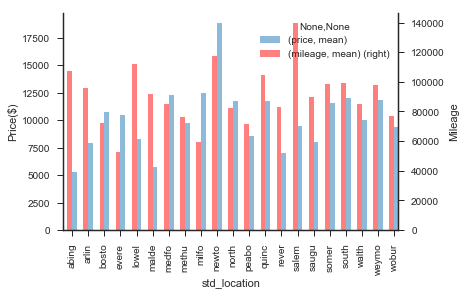

In [267]:
ax = regions['price','mean'].plot.bar(position=0, width=0.3, alpha=0.5, legend=True)#, title='Average Price and Mileage of Used Honda Civics, by region')
ax.set_ylabel('Price($)')
ax = regions['mileage','mean'].plot.bar(secondary_y=True, color='red', position=1, width=0.3, alpha=0.5, legend=True)
ax.set_ylabel('Mileage')
#ax.set_ylim(bottom=1990, top=2010)
sns.despine(top=True, right=False)
fig=ax.get_figure()
#fig.savefig('price_mileage_region.pdf', bbox_inches='tight')

In [262]:
all_car_info.loc['/sob/cto/5969062998.html', 'mileage'] = np.nan
print all_car_info.loc['/sob/cto/5969062998.html']

description     2010 Nissan Altima.2.5s.90k miles.
location                                  Abington
price                                         7995
mileage                                        NaN
region                                        sob/
year                                          2010
std_location                                 abing
Name: /sob/cto/5969062998.html, dtype: object


In [ ]:
from scipy.stats import linregress

In [ ]:
print linregress(df['mileage'][~df['price'].isnull()].dropna(), df['price'][~df['mileage'].isnull()].dropna())
print linregress(df['year'][~df['price'].isnull()].dropna(), df['price'][~df['year'].isnull()].dropna())
print linregress(df['year'][~df['mileage'].isnull()].dropna(), df['mileage'][~df['year'].isnull()].dropna())

In [ ]:
import pandas_profiling

In [ ]:
pandas_profiling.ProfileReport(df)

In [ ]:
print df['price'].argmax()
print df.ix[305]

In [ ]:
print df.ix

In [ ]:
def draw_regional_fig(make, model, year):
    listings = []
    make_model = "{0} {1}".format(make,model)
    min_auto_year = int(year) - 2
    max_auto_year = int(year) + 2
    if max_auto_year > 2016:
        max_auto_year = 2016
    for i in range(0, 500, 100):
        car_results = fetch(auto_make_model=make_model, min_auto_year=min_auto_year, max_auto_year=max_auto_year, s=i)
        doc = parse(car_results[0])
        listings.extend(extract_listings(doc))
    
    df = pd.DataFrame(data=listings)
    if len(df) == 0: return "No results found, check your spelling"
    df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
    df['price'] = df.apply(lambda row: get_price(row['price']), axis=1)
    df['region'] = df['link'].str[1:5]
    df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
    
    regions = df.groupby('region').mean()
    regions = regions.append(pd.Series(data={'year': np.mean(df['year']), 'price': np.mean(df['price']), 'mileage': np.mean(df['mileage'])}, name='AVERAGE'))
    
    my_title = 'Average Price and Mileage of Used {0} {1}, {2}-{3}, by region, n={4}'.format(make, model, min_auto_year, max_auto_year, len(df))
    ax = regions['price'].plot.bar(position=0, width=0.3, alpha=0.5, legend=True, title=my_title)
    ax.set_ylabel('Price($)')
    ax = regions['mileage'].plot.bar(secondary_y=True, color='green', position=1, width=0.3, alpha=0.5, legend=True)
    ax.set_ylabel('Mileage')
    sns.despine(top=True, right=False)
    fig=ax.get_figure()
    
    return fig